In [45]:
import torch
import math
import matplotlib.pyplot as plt
from interpol import resize, spline_coeff, grid_pull
from interpol.padding import pad
from interpol.energies import coeff_upsample2, flowconv, make_splinekernels1d
from scipy.ndimage import spline_filter1d, map_coordinates

F = torch.nn.functional

torch.set_default_dtype(torch.float64)

SCIPY = False
if SCIPY:
    def pull(c, x):
        return torch.as_tensor(map_coordinates(c, x[None], order=3, mode='grid-wrap', prefilter=False))
    def filter(s):
        return torch.as_tensor(spline_filter1d(s, order=3, mode='grid-wrap'))
    def ifilter(c):
        return torch.as_tensor(map_coordinates(c, torch.arange(len(c))[None], order=3, mode='grid-wrap', prefilter=False))
else:
    def pull(c, x):
        return grid_pull(c, x[:, None], 3, bound='dft', extrapolate=True)
    def filter(s):
        return spline_coeff(s, 3, 'dft')
    def ifilter(c):
        return flowconv(c[:, None], make_splinekernels1d(3)[0], 'dft')[:, 0]

In [54]:
N = 8
coeff = torch.randn([N])

In [55]:
FF1 = [1/5040, 1/42, 397/1680, 151/315, 397/1680, 1/42, 1/5040]
FF2_evn = [1/5160960, 69379/5160960, 835637/2580480, 1451347/2580480, 515429/5160960, 2183/5160960]
FF2_odd = FF2_evn[::-1]

FF1 = torch.as_tensor(FF1)
FF2_odd = torch.as_tensor(FF2_odd)
FF2_evn = torch.as_tensor(FF2_evn)

In [56]:
# def up2(coeff):
#     coeff_pad = pad(coeff, [3, 2], 'dft')
#     coeff_conv_evn = F.conv1d(coeff_pad[None, None], FF2_evn[None, None])[0, 0]
#     coeff_pad = pad(coeff, [2, 3], 'dft')
#     coeff_conv_odd = F.conv1d(coeff_pad[None, None], FF2_odd[None, None])[0, 0]
#     coeff_conv = coeff.new_empty([2*len(coeff)])
#     coeff_conv[0:-1:2] = coeff_conv_evn
#     coeff_conv[1::2] = coeff_conv_odd

#     coeff_fourier = torch.fft.fft(coeff_conv)
#     padsize = len(coeff_conv) - len(FF1)
#     halfpad = int(math.ceil(padsize / 2))
#     kernel_fourier = pad(FF1, [halfpad, padsize-halfpad])
#     kernel_fourier = torch.fft.fft(torch.fft.ifftshift(kernel_fourier))
#     coeff_up = torch.fft.ifft(coeff_fourier / kernel_fourier).real
#     return coeff_up

up2 = lambda x: coeff_upsample2(x, 3)

coeff_up2 = up2(coeff)
coeff_up4 = up2(coeff_up2)
coeff_up8 = up2(coeff_up4)


In [57]:
xN = lambda K: torch.linspace(-0.5 * (1 - 1/K), N-1 + 0.5 * (1 - 1/K), K*N)

x = xN(2)
signal = pull(coeff, x)
coeff2 = filter(signal)

x = xN(4)
signal = pull(coeff, x)
coeff4 = filter(signal)

x = xN(8)
signal = pull(coeff, x)
coeff8 = filter(signal)

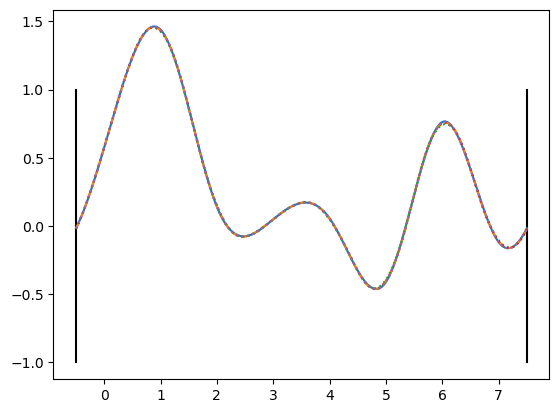

In [58]:
M = 512
x1 = torch.linspace(-0.5, 8*1-0.5, M)
x2 = torch.linspace(-0.5, 8*2-0.5, M)
x4 = torch.linspace(-0.5, 8*4-0.5, M)
x8 = torch.linspace(-0.5, 8*8-0.5, M)
plt.plot([-0.5, -0.5], [-1, 1], 'black')
plt.plot([7.5, 7.5], [-1, 1], 'black')
ax1 = plt.plot(x1, pull(coeff, x1))[0]
ax2 = plt.plot(x1, pull(coeff_up2, x2), '--')[0]
ax3 = plt.plot(x1, pull(coeff2, x2), ':')[0]
ax3 = plt.plot(x1, pull(coeff_up4, x4), ':')[0]
ax3 = plt.plot(x1, pull(coeff4, x4), ':')[0]
# plt.legend([ax1, ax2, ax3], ['original', 'continuous minimizer', 'discrete minimizer'])
plt.show()

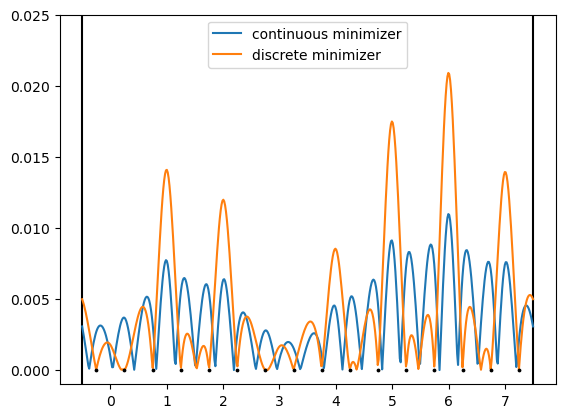

In [63]:
plt.plot([-0.5, -0.5], [-1, 1], 'black')
plt.plot([7.5, 7.5], [-1, 1], 'black')
ref = pull(coeff, x1)
# ax2 = plt.plot(x1, (pull(coeff_up2, x2) - ref).abs(), '-')[0]
# ax3 = plt.plot(x1, (pull(coeff2, x2) - ref).abs(), '-')[0]
# plt.scatter(xN(4), [0]*(8*4), 3, 'k', zorder=1000)
ax2 = plt.plot(x1, (pull(coeff_up2, x2) - ref).abs(), '-')[0]
ax3 = plt.plot(x1, (pull(coeff2, x2) - ref).abs(), '-')[0]
plt.scatter(xN(2), [0]*(2*8), 3, 'k', zorder=1000)
plt.legend([ax2, ax3], ['continuous minimizer', 'discrete minimizer'])
plt.ylim([-0.001, 0.025])
plt.show()

In [64]:
print((pull(coeff_up2, x2) - ref).abs().max())
print((pull(coeff2, x2) - ref).abs().max())

print((pull(coeff_up4, x4) - ref).abs().max())
print((pull(coeff4, x4) - ref).abs().max())

print((pull(coeff_up8, x8) - ref).abs().max())
print((pull(coeff8, x8) - ref).abs().max())

tensor(0.0110)
tensor(0.0209)
tensor(0.0100)
tensor(0.0030)
tensor(0.0099)
tensor(0.0004)
